In [66]:
import os

In [67]:
os.chdir('/Users/dimitrikestenbaum/Desktop/RecSys')

In [68]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import surprise 
from sklearn.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import SVD
from IESEGRecSys import eval
from surprise import KNNBasic, SVD, CoClustering, Dataset, Reader

In [69]:
def two_dig(num):
    """
    This function takes a number as input and casts it to a string. 
    If the length of the str is equal to 1 it concatenates a 0 in front of it.
    This can be applyed to day and month columns that are recorded a single digit 
    in order to meet the two-digit format native to most datetime formats. 
    
    Params: num: A 
    """
    if len(str(num)) == 1:
        return((str(0) + str(num)))
    else:
        return(str(num))

In [70]:
# read in CSV data
artist_df = pd.read_table('Data-20220224/Data Group Assignment/Artists.dat')
tags_df = pd.read_table('Data-20220224/Data Group Assignment/tags.dat',encoding='latin-1')
user_artists_df = pd.read_table('Data-20220224/Data Group Assignment/user_artists.dat')
user_tagged_artists_df = pd.read_table('Data-20220224/Data Group Assignment/user_taggedartists.dat')


In [71]:
# train-test split
train, test = train_test_split(user_artists_df, test_size=0.3, random_state=123)

# reset index
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(train.shape)
print(test.shape)

(64983, 3)
(27851, 3)


In [72]:
len(user_artists_df)

92834

In [73]:
len(train)

64983

In [74]:
user_tagged_artists_df.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [75]:
# apply two_dig to day and month cols
user_tagged_artists_df['day'] = user_tagged_artists_df['day'].map(lambda x: two_dig(x))

user_tagged_artists_df['month'] = user_tagged_artists_df['month'].map(lambda x: two_dig(x))

In [76]:
# create release date column by concatenating all data info and casting to datetime 

user_tagged_artists_df['release_date'] = pd.to_datetime((user_tagged_artists_df['year'].astype('str') + user_tagged_artists_df['day'] + user_tagged_artists_df['month']),format='%Y%d%m')

(array([4.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 2.13500e+03, 1.84339e+05]),
 array([-4962. , -2955.5,  -949. ,  1057.5,  3064. ,  5070.5,  7077. ,
         9083.5, 11090. , 13096.5, 15103. ]),
 <BarContainer object of 10 artists>)

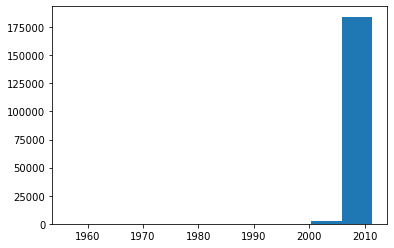

In [77]:
# check distribution of dates
plt.hist(user_tagged_artists_df['release_date'])
#highly skewed

In [78]:
#create date thresholds for binning dates in ranges
thresholdMin = pd.to_datetime('1956-06-01')
thresholdVeryOld = pd.to_datetime('1970-01-01') # represents the range from 1956 - 1970 
thresholdOld = pd.to_datetime('1984-01-01')# represents the range from 1970 - 1984 
thresholdNew = pd.to_datetime('1998-01-01')# represents the range from 1984 - 1998 
thresholdVeryNew = pd.to_datetime('2012-01-01')# represents the range from 1998 - 2012

In [79]:
user_tagged_artists_df['very_old'] = ((user_tagged_artists_df.release_date >= thresholdMin) & (user_tagged_artists_df.release_date < thresholdVeryOld)).astype(int)
user_tagged_artists_df['old'] = ((user_tagged_artists_df.release_date >= thresholdVeryOld) & (user_tagged_artists_df.release_date < thresholdOld)).astype(int)
user_tagged_artists_df['new'] = ((user_tagged_artists_df.release_date >= thresholdOld) & (user_tagged_artists_df.release_date < thresholdNew)).astype(int)
user_tagged_artists_df['very_new'] = ((user_tagged_artists_df.release_date >= thresholdNew) & (user_tagged_artists_df.release_date < thresholdVeryNew)).astype(int)

In [80]:
 # merge together to get the full list of artist IDs
user_tagged_artists_df=pd.merge(user_artists_df,user_tagged_artists_df, on="artistID",how='left').fillna(0)

In [81]:
len(user_tagged_artists_df)

10948843

In [82]:
# drop uneeded columns
user_tagged_artists_df = user_tagged_artists_df[["userID_x","artistID","tagID",'very_old','old','new','very_new']]
user_tagged_artists_df.columns =["userID","artistID","tagID",'very_old','old','new','very_new']

In [83]:
user_tagged_artists_df.head()

,userID,artistID,tagID,very_old,old,new,very_new
0,2,51,16.0,0.0,0.0,0.0,1.0
1,2,51,25.0,0.0,0.0,0.0,1.0
2,2,51,16.0,0.0,0.0,0.0,1.0
3,2,51,25.0,0.0,0.0,0.0,1.0
4,2,51,16.0,0.0,0.0,0.0,1.0


In [84]:
len(user_tagged_artists_df)

10948843

## Content Based Recommendation

In [85]:
#merging the dataset for content-based 
df_content_based = pd.merge(user_tagged_artists_df,tags_df,on="tagID",how="outer").fillna(0)

In [86]:
df_content_based.head()

,userID,artistID,tagID,very_old,old,new,very_new,tagValue
0,2.0,51.0,16.0,0.0,0.0,0.0,1.0,new wave
1,2.0,51.0,16.0,0.0,0.0,0.0,1.0,new wave
2,2.0,51.0,16.0,0.0,0.0,0.0,1.0,new wave
3,2.0,51.0,16.0,0.0,0.0,0.0,1.0,new wave
4,2.0,51.0,16.0,0.0,0.0,0.0,1.0,new wave


In [87]:
#pivoting the table (creating a dummies table)
df_content_based = df_content_based.pivot_table(index=["artistID","very_old",'old','new','very_new'], columns = ["tagValue"], aggfunc={'tagValue':np.count_nonzero}).fillna(0)

In [88]:
df_content_based.reset_index(inplace=True)

In [89]:
df_content_based.head()

artistID very_old  old  new very_new tagValue            \
tagValue                                             0   #1 '80s   
0             0.0      0.0  0.0  0.0      0.0      0.0  1.0  0.0   
1             1.0      0.0  0.0  0.0      1.0      0.0  0.0  0.0   
2             2.0      0.0  0.0  0.0      1.0      0.0  0.0  0.0   
3             3.0      0.0  0.0  0.0      1.0      0.0  0.0  0.0   
4             4.0      0.0  0.0  0.0      1.0      0.0  0.0  0.0   

                                    ...                                    \
tagValue -pearl fashion music   -q  ... zornish zorro zorro musical zosia   
0                         0.0  1.0  ...     0.0   1.0           1.0   1.0   
1                         0.0  0.0  ...     0.0   0.0           0.0   0.0   
2                         0.0  0.0  ...     0.0   0.0           0.0   0.0   
3                         0.0  0.0  ...     0.0   0.0           0.0   0.0   
4                         0.0  0.0  ...     0.0   0.0           0.0   0.0   

                                          
tagValue zouk  ztt   zu zulu zveri zydzi  
0         1.0  0.0  0.0  1.0   1.0   1.0  
1         0.0  0.0  0.0  0.0   0.0   0.0  
2         0.0  0.0  0.0  0.0   0.0   0.0  
3         0.0  0.0  0.0  0.0   0.0   0.0  
4         0.0  0.0  0.0  0.0   0.0   0.0  

[5 rows x 11952 columns]

In [91]:
df_content_based = df_content_based[df_content_based['artistID'].isin(train.artistID)]

In [96]:
df_content_based.reset_index(drop=False, inplace=True)

In [97]:
df_content_based.drop(columns=['index'],inplace=True,axis=1)

/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [98]:
df_content_based.head()

artistID very_old  old  new very_new tagValue            \
tagValue                                             0   #1 '80s   
0             1.0      0.0  0.0  0.0      1.0      0.0  0.0  0.0   
1             2.0      0.0  0.0  0.0      1.0      0.0  0.0  0.0   
2             3.0      0.0  0.0  0.0      1.0      0.0  0.0  0.0   
3             4.0      0.0  0.0  0.0      1.0      0.0  0.0  0.0   
4             5.0      0.0  0.0  0.0      1.0      0.0  0.0  0.0   

                                    ...                                    \
tagValue -pearl fashion music   -q  ... zornish zorro zorro musical zosia   
0                         0.0  0.0  ...     0.0   0.0           0.0   0.0   
1                         0.0  0.0  ...     0.0   0.0           0.0   0.0   
2                         0.0  0.0  ...     0.0   0.0           0.0   0.0   
3                         0.0  0.0  ...     0.0   0.0           0.0   0.0   
4                         0.0  0.0  ...     0.0   0.0           0.0   0.0   

                                          
tagValue zouk  ztt   zu zulu zveri zydzi  
0         0.0  0.0  0.0  0.0   0.0   0.0  
1         0.0  0.0  0.0  0.0   0.0   0.0  
2         0.0  0.0  0.0  0.0   0.0   0.0  
3         0.0  0.0  0.0  0.0   0.0   0.0  
4         0.0  0.0  0.0  0.0   0.0   0.0  

[5 rows x 11952 columns]

In [99]:
cb= pd.DataFrame(df_content_based)

In [100]:
cb.head()

artistID very_old  old  new very_new tagValue            \
tagValue                                             0   #1 '80s   
0             1.0      0.0  0.0  0.0      1.0      0.0  0.0  0.0   
1             2.0      0.0  0.0  0.0      1.0      0.0  0.0  0.0   
2             3.0      0.0  0.0  0.0      1.0      0.0  0.0  0.0   
3             4.0      0.0  0.0  0.0      1.0      0.0  0.0  0.0   
4             5.0      0.0  0.0  0.0      1.0      0.0  0.0  0.0   

                                    ...                                    \
tagValue -pearl fashion music   -q  ... zornish zorro zorro musical zosia   
0                         0.0  0.0  ...     0.0   0.0           0.0   0.0   
1                         0.0  0.0  ...     0.0   0.0           0.0   0.0   
2                         0.0  0.0  ...     0.0   0.0           0.0   0.0   
3                         0.0  0.0  ...     0.0   0.0           0.0   0.0   
4                         0.0  0.0  ...     0.0   0.0           0.0   0.0   

                                          
tagValue zouk  ztt   zu zulu zveri zydzi  
0         0.0  0.0  0.0  0.0   0.0   0.0  
1         0.0  0.0  0.0  0.0   0.0   0.0  
2         0.0  0.0  0.0  0.0   0.0   0.0  
3         0.0  0.0  0.0  0.0   0.0   0.0  
4         0.0  0.0  0.0  0.0   0.0   0.0  

[5 rows x 11952 columns]

## collaborative filtering data prep

In [34]:
#discretize weights using qcuts 
user_artists_df['weight_quantiles'] = pd.qcut(user_artists_df['weight'],
                           q=[0,.2,.4,.6,.8,1],
                           labels=False,
                           precision=0)
user_artists_df=user_artists_df.drop(["weight"], axis = 1)

## Train test split

In [103]:
# check whether the artisit IDs are all included in the content based matrix 
train[-train["artistID"].isin(cb.index.values)]

,userID,artistID,weight
37,1499,15028,475
48,2045,14693,1685
145,2095,18672,110
195,1722,16316,50
217,1621,15621,239
...,...,...,...
64850,1505,15096,413
64881,2056,18454,10
64911,1659,15906,406
64958,1625,15674,8


## Applying Surprise Recommendation Algos

In [39]:
#creat reader, trainset, and test objects
reader = surprise.Reader(rating_scale=(1, 5))
df_train = surprise.Dataset.load_from_df(train, reader).build_full_trainset()
df_test = list(test.itertuples(index=False, name=None))

## Applying collaborative filtering models

In [85]:
# user-based
options = {'name':'cosine', 'user_based':True}
ub = KNNBasic(k=15, min_k=5, sim_options=options, random_state=42)

# item-based
options = {'name':'cosine', 'user_based':False}
ib = KNNBasic(k=15, min_k=5, sim_options=options, random_state=42)

# svd
mf = SVD(n_factors=20, biased=False, random_state=42)

# clustering
clust = CoClustering(n_cltr_u=10, n_cltr_i=10, n_epochs=50, random_state=42)


In [86]:
#evaluating the models
models = {"UB_15":ub, "IB_15":ib, "SVD_20":mf, "Clust_10_10":clust}
overview = pd.concat([eval.evaluate(mod.fit(df_train).test(df_test), topn=5, rating_cutoff=4) for mod in models.values()], axis=1)
overview.columns = list(models.keys())

overview

Computing the cosine similarity matrix...


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the cosine similarity matrix...


/Users/dimitrikestenbaum/opt/anaconda3/lib/python3.9/site-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.


/var/folders/fc/9vrqth010qgbrhv1th35kb040000gn/T/ipykernel_51773/1368943603.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  overview = pd.concat([eval.evaluate(mod.fit(df_train).test(df_test), topn=5, rating_cutoff=4) for mod in models.values()], axis=1)


,UB_15,IB_15,SVD_20,Clust_10_10
RMSE,1.393631,1.117180,1.217409,1.074960
MAE,1.183930,0.897713,0.968265,0.864092
Recall,0.000180,0.134892,0.080216,0.156115
Precision,0.250000,0.976562,0.867704,0.745704
F1,0.000359,0.237042,0.146855,0.258180
NDCG@5,0.866736,0.861017,0.868794,0.860111


In [87]:
print(len(df_content_based.columns))
print(len(pd.unique(df_content_based.columns)))

11952
11952


## Applying content based rec sys

In [40]:
from sklearn.metrics.pairwise import cosine_similarity
import surprise

# Content Based as a Class
class ContentBased:

    def __init__(self, NN):
        self.NN = NN
        self.fitted = {"content":False, "ratings":False}
        
    def fit(self, content_data):

        self.items = content_data.index.values
        self.item_dim = len(self.items)
        # check for duplicate items
        assert (len(self.items) == len(set(self.items))), "Duplicate items in content data!"

        # compute similarity
        self.matrix = cosine_similarity(content_data.values)
        np.fill_diagonal(self.matrix, 0)
        
        self.matrixNN = self.matrix.copy()

        # filter similarity matrix for NN nearest neighbors (constraint: non-negative similarity)
        for i in range(self.item_dim):
            crit_val = max(-np.sort(-self.matrix[i])[self.NN-1], 0)
            self.matrixNN[i][self.matrixNN[i] < crit_val] = 0.0
        
        self.fitted["content"] = True

    # helper -> transform surprise.trainset.Trainset to pd.DataFrame
    def _trainset2list(self, trainset):
        return pd.DataFrame([(trainset.to_raw_uid(u), trainset.to_raw_iid(i), r) for (u, i, r) in trainset.all_ratings()], columns=["user", "item", "rating"])

    def fit_ratings(self, df):

        if not self.fitted["content"]:
            raise Exception("Fit model on content data!")

        if isinstance(df, surprise.trainset.Trainset):
            df = self._trainset2list(df)
        
        # fix unknown items
        unknown_items = list(set(df["item"]) - set(self.items))
        if len(unknown_items) > 0:
            print(f"Warning {len(unknown_items)} items are not included in content data: {unknown_items}")
        df = df[df["item"].isin(self.items)].reset_index(drop=True)

        # store user data
        self.users = np.unique(df["user"])
        self.user_dim = len(self.users)

        # fix missing items
        missing_items = list(set(self.items) - set(df["item"]))
        if len(missing_items) > 0: 
            fix_df = pd.DataFrame([{"user":np.nan, "item":i, "rating":np.nan} for i in missing_items])
            df = df.append(fix_df).reset_index(drop=True)

        # pivot 
        df_pivot = df.pivot_table(index='user', values='rating', columns='item', dropna=False).reindex(self.users)

        # row-wise (user) average
        self.user_avg = np.array(np.mean(df_pivot, axis=1))
        self.global_mean = np.mean(self.user_avg)

        # center ratings
        df_pivot = df_pivot.sub(self.user_avg, axis=0).fillna(0)

        # predict ratings for each item 
        denom = self.matrixNN.sum(axis=0) # column sums
        self.prediction = (np.matmul(df_pivot.values, self.matrixNN) / denom) + self.user_avg[:,np.newaxis]

        # replace NA values with mean
        # prediction[np.isnan(prediction)] = self.global_mean

        self.fitted["ratings"] = True
    
    # get predicted value for user-item combination
    def predict(self, user, item, r_ui=None):
        details = {"was_impossible":False}

        # check whether user and item are unknown -> default = global average rating
        if self.knows_user(user) & self.knows_item(item):

            # convert user & item in internal ids
            iid = np.where(self.items == item)[0].item()
            uid = np.where(self.users == user)[0].item()

            # inference prediction
            est = self.prediction[uid, iid]
            
            if np.isnan(est): 
                est = self.global_mean
                details["was_impossible"] = True
            return surprise.Prediction(user, item, r_ui, est, details)
        
        else:
            details["was_impossible"] = True
            details["reason"] = "User or item unknown"
            return surprise.Prediction(user, item, r_ui, self.global_mean, details)

    # predict entire testset
    def test(self, testset):
        if not self.fitted["ratings"]:
            raise Exception("Fit model on ratings data!")
        return [self.predict(user=u,item=i,r_ui=r) for (u,i,r) in testset]

    def knows_user(self, user):
        return user in self.users   

    def knows_item(self, item):
        return item in self.items        

    # get topn most similar items 
    def get_most_similar(self, item, topn=5):

        # get iid
        if self.knows_item(item):
            iid = np.where(self.items == item)[0].item()
        else:
            raise Exception(f"Item {item} unknown ...")
        
        list_iids = (-self.matrix[iid]).argsort()[:topn]
        return self.items[list_iids]

    def get_similarities(self):
        print('Cosine similarities shape: ({}, {}) items x items'.format(self.item_dim, self.item_dim))
        return self.matrix

In [60]:
# init content-based
cb_mod = ContentBased(NN=10)

# fit on content
cb_mod.fit(cb)

# fit on train_ratings
cb_mod.fit_ratings(df_train)
    
# predict test ratings
cb_pred = cb_mod.test(df_test)

/var/folders/fc/9vrqth010qgbrhv1th35kb040000gn/T/ipykernel_53984/2647039970.py:71: RuntimeWarning: invalid value encountered in true_divide
  self.prediction = (np.matmul(df_pivot.values, self.matrixNN) / denom) + self.user_avg[:,np.newaxis]


In [61]:
# compute metrics for CB RS
cb_res = eval.evaluate(cb_pred, topn=5, rating_cutoff=4).rename(columns={'value':'Content_based_10'})
cb_res

,Content_based_10
RMSE,3191.049987
MAE,644.109816
Recall,0.999380
Precision,0.990679
F1,0.995011
NDCG@5,0.845510


In [91]:
#get summary for all models applied
overview = pd.concat([overview, cb_res], axis=1)
overview

,UB_15,IB_15,SVD_20,Clust_10_10,Content_based_10
RMSE,1.393631,1.117180,1.217409,1.074960,0.922935
MAE,1.183930,0.897713,0.968265,0.864092,0.694115
Recall,0.000180,0.134892,0.080216,0.156115,0.144604
Precision,0.250000,0.976562,0.867704,0.745704,0.997519
F1,0.000359,0.237042,0.146855,0.258180,0.252592
NDCG@5,0.866736,0.861017,0.868794,0.860111,0.873643
